In [1]:
import numpy as np
import os
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from scipy.signal import lfilter
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import parselmouth
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv(r"C:\Users\jmdgo\Downloads\binary_labeled_dataset.csv")

In [3]:
clip_path = r"C:\Users\jmdgo\Downloads\extracted_clips\extracted_clips"

In [4]:
audio_paths = []
for folder in os.listdir(clip_path):
    folder_path = os.path.join(clip_path, folder)
    #episode_paths = []
    for episode in os.listdir(folder_path):
        episode_path = os.path.join(folder_path, episode)
        for wav in os.listdir(episode_path):
            wav_path = os.path.join(episode_path, wav)
            audio_paths.append(wav_path)

In [5]:
df['audio_path'] = ['default'] * len(df)

In [6]:
for path in audio_paths:
    filename = os.path.basename(path)
    parts = filename.split('_')
    podcast_name = parts[0]
    episode_number = int(parts[1])
    clip_number = int(parts[2].split('.')[0]) 

    match_row = df[(df['Show'] == podcast_name) & (df['EpId'] == episode_number) & (df['ClipId'] == clip_number)]
    if not match_row.empty:
        match_index = match_row.index[0]
        df.at[match_index, 'audio_path'] = path

In [7]:
value_counts = df['Stutter'].value_counts()
total_rows = df.shape[0]

percentage_per_class = (value_counts / total_rows) * 100

print(percentage_per_class)

0    60.677123
1    39.322877
Name: Stutter, dtype: float64


In [9]:
def extract_mfcc(audio_file, num_mfcc=40):
    audio, sr = librosa.load(audio_file, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc)
    mfccs_flat = mfccs.T.flatten()
    return mfccs_flat

def extract_zcr(audio_file, frame_length=2048, hop_length=512):
    audio, sr = librosa.load(audio_file, sr=None)
    zcr = librosa.feature.zero_crossing_rate(audio, frame_length=frame_length, hop_length=hop_length)
    return zcr.flatten()

def extract_jitter_shimmer(audio_file):
    sound = parselmouth.Sound(audio_file)
    pitch = sound.to_pitch()
    pulses = parselmouth.praat.call([sound, pitch], "To PointProcess (cc)")
    jitter = parselmouth.praat.call(pulses, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    shimmer = parselmouth.praat.call([sound, pulses], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    return jitter, shimmer

def extract_all_features(audio_file, num_mfcc=40, frame_length=2048, hop_length=512):
    mfcc_features = extract_mfcc(audio_file, num_mfcc)
    zcr_features = extract_zcr(audio_file, frame_length, hop_length)
    jitter, shimmer = extract_jitter_shimmer(audio_file)
    return np.concatenate([mfcc_features, zcr_features, [jitter, shimmer]])

In [10]:
audio_files = df['audio_path'] 
labels = df['WordRep']

In [11]:
df_WordRep = df[['audio_path', 'WordRep']]

In [12]:
df_WordRep_1 = df_WordRep[df_WordRep['WordRep']==1]

In [13]:
df_WordRep_0 = df[(df['Prolongation']==0) & 
                        (df['Block']==0) & 
                        (df['Interjection']==0) & 
                        (df['WordRep']==0) & 
                        (df['SoundRep']==0) &
                        (df['NoStutteredWords']==1)]


In [14]:
df_WordRep_1.shape

(2358, 2)

In [16]:
df_WordRep_0_sampled = df_WordRep_0.sample(2358)

In [17]:
df_WordRep_0_sampled.shape

(2358, 17)

In [18]:
df_WordRep_data = pd.concat([df_WordRep_0_sampled, df_WordRep_1], ignore_index=True, axis=0)

In [19]:
df_WordRep_data.shape

(4716, 17)

In [20]:
df_WordRep.head(2)

,audio_path,WordRep
0,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0
1,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0


In [21]:
value_counts = df_WordRep_data['WordRep'].value_counts()
total_rows = df_WordRep_data.shape[0]

percentage_per_class = (value_counts / total_rows) * 100

print(percentage_per_class)

0    50.0
1    50.0
Name: WordRep, dtype: float64


In [22]:
X = np.array(df_WordRep_data['audio_path'])
y = np.array(df_WordRep_data['WordRep'])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, stratify = y)

In [24]:
mfcc_features_train = Parallel(n_jobs=-1)(delayed(extract_mfcc)(audio_file) for audio_file in X_train)
mfcc_features_test = Parallel(n_jobs=-1)(delayed(extract_mfcc)(audio_file) for audio_file in X_test)
zcr_features_train = Parallel(n_jobs=-1)(delayed(extract_zcr)(audio_file) for audio_file in X_train)
zcr_features_test = Parallel(n_jobs=-1)(delayed(extract_zcr)(audio_file) for audio_file in X_test)

jitter_shimmer_train = Parallel(n_jobs=-1)(delayed(extract_jitter_shimmer)(audio_file) for audio_file in X_train)
jitter_shimmer_test = Parallel(n_jobs=-1)(delayed(extract_jitter_shimmer)(audio_file) for audio_file in X_test)

jitter_train, shimmer_train = zip(*jitter_shimmer_train)
jitter_test, shimmer_test = zip(*jitter_shimmer_test)

zcr_features_train = Parallel(n_jobs=-1)(delayed(extract_zcr)(audio_file) for audio_file in X_train)
zcr_features_test = Parallel(n_jobs=-1)(delayed(extract_zcr)(audio_file) for audio_file in X_test)

features_train = np.array([np.hstack((mfcc, zcr)) for mfcc, zcr in zip(mfcc_features_train, zcr_features_train)])
features_test = np.array([np.hstack((mfcc, zcr)) for mfcc, zcr in zip(mfcc_features_test, zcr_features_test)])

In [25]:
merged_features_train = np.column_stack((mfcc_features_train, zcr_features_train, jitter_train, shimmer_train))
merged_features_test = np.column_stack((mfcc_features_test, zcr_features_test, jitter_test, shimmer_test))

print(merged_features_train.shape)
print(merged_features_test.shape)

(3301, 3856)
(1415, 3856)


In [26]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((3301,), (1415,), (3301,), (1415,))

In [27]:
nan_indices_train = np.argwhere(np.isnan(merged_features_train))
if len(nan_indices_train) > 0:
    print("NaN values found in training data at indices:", nan_indices_train)
else:
    print("No NaN values found in training data")

# Check for NaN values in testing data
nan_indices_test = np.argwhere(np.isnan(merged_features_test))
if len(nan_indices_test) > 0:
    print("NaN values found in testing data at indices:", nan_indices_test)
else:
    print("No NaN values found in testing data")

NaN values found in training data at indices: [[  96 3854]
 [  96 3855]
 [1100 3855]
 [1496 3854]
 [1496 3855]
 [2520 3854]
 [2520 3855]]
NaN values found in testing data at indices: [[ 589 3854]
 [ 589 3855]
 [ 614 3854]
 [ 614 3855]]


In [28]:
from sklearn.impute import KNNImputer
# KNN imputation
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors as needed

# Fit imputer on training data and transform both training and testing data
merged_features_train = imputer.fit_transform(merged_features_train)
merged_features_test = imputer.transform(merged_features_test)

# Check if any NaN values remain after imputation
nan_indices_train = np.argwhere(np.isnan(merged_features_train))
if len(nan_indices_train) > 0:
    print("NaN values still present in imputed training data at indices:", nan_indices_train)
else:
    print("No NaN values found in imputed training data")

nan_indices_test = np.argwhere(np.isnan(merged_features_test))
if len(nan_indices_test) > 0:
    print("NaN values still present in imputed testing data at indices:", nan_indices_test)
else:
    print("No NaN values found in imputed testing data")


No NaN values found in imputed training data
No NaN values found in imputed testing data


In [30]:
from sklearn.decomposition import PCA

# Assuming merged_features_train and merged_features_test are your feature arrays

# Merge the training and testing data
merged_data = np.concatenate((merged_features_train, merged_features_test), axis=0)

# Apply PCA
pca = PCA(n_components=50)  # You can specify the number of principal components as needed
transformed_data = pca.fit_transform(merged_data)

# Print the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.24778653 0.15632687 0.04659932 0.03814196 0.03333837 0.0299441
 0.0278395  0.01992707 0.01829503 0.01710236 0.01471269 0.01259337
 0.01109808 0.01105278 0.00942105 0.00850567 0.0083739  0.00720376
 0.00638069 0.006122   0.00581438 0.0056173  0.00542596 0.00520031
 0.00464309 0.00440965 0.00424653 0.00408088 0.00395583 0.00368943
 0.00366224 0.00354939 0.00344957 0.00311403 0.00306417 0.00293423
 0.00285715 0.00275122 0.00269917 0.00259841 0.00254493 0.00249555
 0.00235417 0.00230372 0.00229554 0.00220197 0.00213064 0.00209418
 0.0020142  0.00196921]


In [31]:
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

# Count the occurrences of each unique value in y_train
train_distribution = y_train_series.value_counts()

# Count the occurrences of each unique value in y_test
test_distribution = y_test_series.value_counts()

print("Distribution of 0s and 1s in y_train:")
print(train_distribution)

print("\nDistribution of 0s and 1s in y_test:")
print(test_distribution)

Distribution of 0s and 1s in y_train:
1    1651
0    1650
dtype: int64

Distribution of 0s and 1s in y_test:
0    708
1    707
dtype: int64


In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

X_train = np.array(merged_features_train)
X_test = np.array(merged_features_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Convert labels to categorical
y_train_categorical = to_categorical(y_train, num_classes=2)
y_test_categorical = to_categorical(y_test, num_classes=2)

# Reshape features for Conv1D input shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the CNN model
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_categorical, epochs=10, batch_size=32, validation_data=(X_test, y_test_categorical))


Epoch 1/10
104/104 [==============================] - 10s 93ms/step - loss: 12.1015 - accuracy: 0.5338 - val_loss: 0.7845 - val_accuracy: 0.5845
Epoch 2/10
104/104 [==============================] - 10s 92ms/step - loss: 0.6080 - accuracy: 0.6871 - val_loss: 0.6952 - val_accuracy: 0.6092
Epoch 3/10
104/104 [==============================] - 9s 91ms/step - loss: 0.4433 - accuracy: 0.8207 - val_loss: 0.7501 - val_accuracy: 0.6106
Epoch 4/10
104/104 [==============================] - 10s 92ms/step - loss: 0.2989 - accuracy: 0.9006 - val_loss: 0.8258 - val_accuracy: 0.5951
Epoch 5/10
104/104 [==============================] - 10s 92ms/step - loss: 0.1583 - accuracy: 0.9621 - val_loss: 0.9792 - val_accuracy: 0.5816
Epoch 6/10
104/104 [==============================] - 10s 95ms/step - loss: 0.0864 - accuracy: 0.9870 - val_loss: 1.1257 - val_accuracy: 0.5837
Epoch 7/10
104/104 [==============================] - 10s 94ms/step - loss: 0.0430 - accuracy: 0.9973 - val_loss: 1.2844 - val_accuracy:

In [37]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Assuming merged_features_train contains merged features for training data
# Assuming merged_features_test contains merged features for test data
# Assuming y_train contains labels for training data
# Assuming y_test contains labels for test data

# Convert lists to numpy arrays
X_train = np.array(merged_features_train)
X_test = np.array(merged_features_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Convert labels to categorical
y_train_categorical = to_categorical(y_train, num_classes=2)
y_test_categorical = to_categorical(y_test, num_classes=2)

# Reshape features for Conv1D input shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the CNN model
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_categorical, epochs=10, batch_size=32, 
                    validation_data=(X_test, y_test_categorical), callbacks=[early_stopping])


Epoch 1/10
104/104 [==============================] - 11s 95ms/step - loss: 16.1136 - accuracy: 0.5183 - val_loss: 4.1389 - val_accuracy: 0.4996
Epoch 2/10
104/104 [==============================] - 10s 97ms/step - loss: 1.1178 - accuracy: 0.6122 - val_loss: 0.7899 - val_accuracy: 0.5633
Epoch 3/10
104/104 [==============================] - 10s 92ms/step - loss: 0.4696 - accuracy: 0.7776 - val_loss: 0.7654 - val_accuracy: 0.5753
Epoch 4/10
104/104 [==============================] - 10s 92ms/step - loss: 0.3207 - accuracy: 0.8812 - val_loss: 0.8578 - val_accuracy: 0.5682
Epoch 5/10
104/104 [==============================] - 10s 95ms/step - loss: 0.2096 - accuracy: 0.9400 - val_loss: 1.1416 - val_accuracy: 0.5576
Epoch 6/10
104/104 [==============================] - 10s 94ms/step - loss: 0.1408 - accuracy: 0.9670 - val_loss: 1.0305 - val_accuracy: 0.5625


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


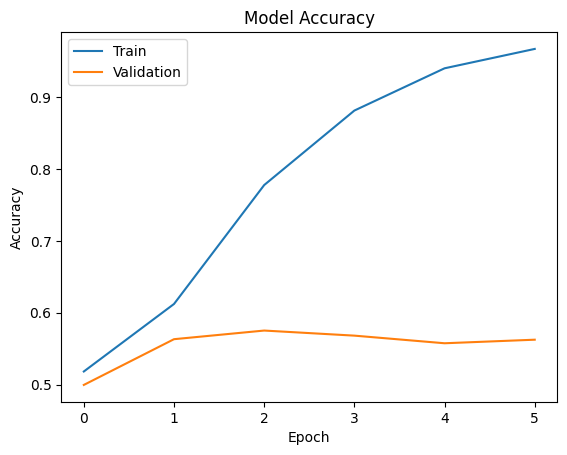

In [38]:
import matplotlib.pyplot as plt
# Print the keys of the history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [39]:
model_file_path = r'C:\Users\jmdgo\Downloads'
model.save("WordRep_mzjs_model.h5")
print("Model saved successfully to:", model_file_path)

Model saved successfully to: C:\Users\jmdgo\Downloads
